### Rough script for working out how to build the evaluation pipeline to be added to the train script

In [1]:
import os
os.chdir('/home/ubuntu/msc-project-master/msc-project-master/')
import argparse
import visdom
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim

from data import NpzFolder, NpzLoader, TBPTTIter
from model import Loop, MaskedMSE
from utils import create_output_dir, wrap, check_grad
from training_monitor import TrainingMonitor
import evaluate_loss_func_for_notebook as el
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [19]:
from training_monitor import *

## Calculate training loss on a randomized subset of the training set
Full training set is too big, but the running loss calculated during training may not be reliable enough to report

In [187]:
dataset = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'
dataset = '/home/ubuntu/loop/data/vctk'
max_seq_len = 1000
batch_size = 64
checkpoint = 'checkpoints/vctk-all-train-mon/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-train-mon-mcd/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-train-mon-noise-2/bestmodel.pth'

In [3]:
train_dataset = NpzFolder(dataset + '/numpy_features', False)
train_loader = NpzLoader(train_dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [4]:
valid_dataset = NpzFolder(dataset + '/numpy_features_valid', False)
valid_loader = NpzLoader(valid_dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True)

In [5]:
len(valid_dataset)

700

In [6]:
train_dataset = NpzFolder(dataset + '/numpy_features', False)
idx = np.random.permutation(len(train_dataset))[:len(valid_dataset)]
train_dataset.npzs = [train_dataset.npzs[i] for i in idx]

In [7]:
train_loader = NpzLoader(train_dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [188]:
checkpoint_args_path = os.path.dirname(checkpoint) + '/args.pth'
checkpoint_args = torch.load(checkpoint_args_path)

opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
train_args = opt[0]
#train_args.noise = 0
train_args.checkpoint = checkpoint

#args_to_use = args
args_to_use = train_args

print args_to_use
model = Loop(args_to_use)

model.cuda()
model.load_state_dict(torch.load(args_to_use.checkpoint, map_location=lambda storage, loc: storage))
criterion = MaskedMSE().cuda()

Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='checkpoints/vctk-us-train-mon-noise-2/bestmodel.pth', clip_grad=0.5, data='/home/ubuntu/loop/data/vctk', epochs=90, eval_epochs=1, expName='checkpoints/vctk-us-train-mon-noise-2', expNameRaw='vctk-us-train-mon-noise-2', gpu=0, hidden_size=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=2, nspk=22, output_size=63, seed=1, seq_len=500, visualize=False, vocabulary_size=44)


In [13]:
avg, my_avg, loss_workings = el.evaluate(model, train_loader, criterion)

Loss 41.46: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


In [14]:
print avg
print my_avg

41.4086966081
41.4086969549


In [15]:
avg, my_avg, loss_workings = el.evaluate(model, valid_loader, criterion)

Loss 41.74: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


In [16]:
print avg
print my_avg

41.5974381187
41.5974381187


### MCD

In [9]:
import eval_mcd as eval_mcd

In [10]:
norm = np.load(valid_loader.dataset.npzs[0])['audio_norminfo']

In [11]:
mcd = eval_mcd.evaluate(model, norm, valid_loader)

Valid (MCD 7.21): 100%|██████████| 11/11 [00:35<00:00,  3.24s/it]


### Attention

In [73]:
valid_dataset_short = NpzFolder(dataset + '/numpy_features_valid', False)
idx = np.random.permutation(len(valid_dataset_short))[:10]
valid_dataset_short.npzs = [valid_dataset_short.npzs[i] for i in idx]

In [74]:
valid_loader_short = NpzLoader(valid_dataset_short,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True,
                         shuffle=True)

In [259]:
model.eval()
model.training

False

In [260]:
avg, my_avg, loss_workings = el.evaluate(model, valid_loader_short, criterion)

Loss 61.96: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


In [261]:
import notebook_utils as nu

In [398]:
idx = 8

In [399]:
attn = loss_workings['attn'][idx]

In [400]:
tmp = dict()
tmp['audio_features'] = loss_workings['output'][idx]
#tmp['audio_features'] = tmp['audio_features'][250:350,:]
nu.play_synthesized_features(tmp, norm_path=dataset + '/norm_info/norm.dat')

complete test.wav.wav.


(16000, array([    0,     0,     0, ...,   159,   142, -1389], dtype=int16))

In [401]:
tmp['audio_features'].shape

(521, 63)

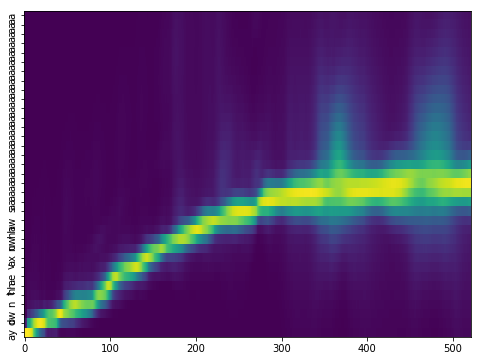

In [402]:
nu.plot_attn(attn, loss_workings['txt'][idx], NpzFolder(dataset + '/numpy_features_valid').dict)

In [403]:
# calculate velocity

In [404]:
r = np.tile(np.array(range(35)).reshape(-1,1), attn.shape[0]).T

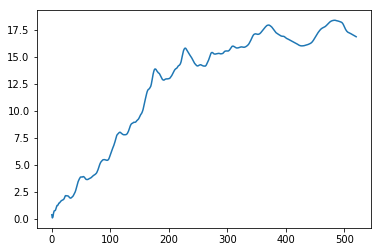

In [405]:
plt.plot((attn * np.array(r)).sum(1) / attn.sum(1))

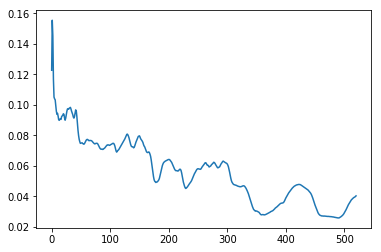

In [406]:
plt.plot((attn/attn.sum(1).reshape(-1,1)).std(1))

In [407]:
tmp = (attn/attn.sum(1).reshape(-1,1)) 

In [408]:
t2 = tmp*r

In [409]:
t2.cumsum()

array([  0.00000000e+00,   2.34652579e-01,   3.22886959e-01, ...,
         6.55806644e+03,   6.55829479e+03,   6.55851195e+03])

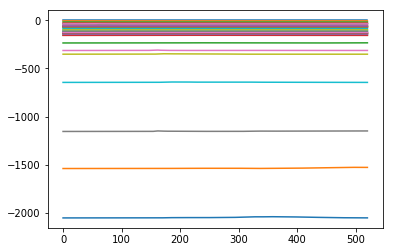

In [410]:
plt.plot(t22)

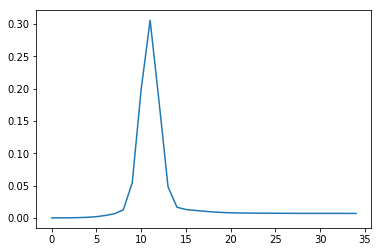

In [411]:
plt.plot(tmp[200,:])

In [412]:
x = attn.cumsum(1)/attn.sum(1).reshape(-1,1)

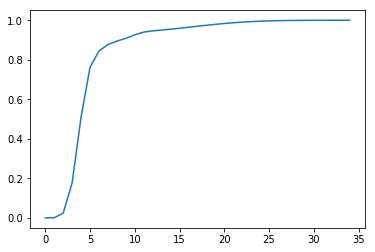

In [413]:
plt.plot(x[90,:])

In [414]:
rng = np.logical_and(x>0.1, x<0.9).sum(1)

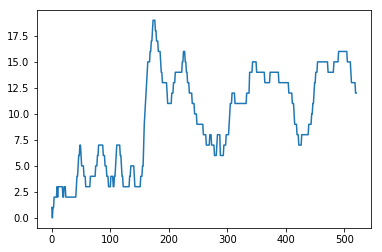

In [415]:
plt.plot(rng)

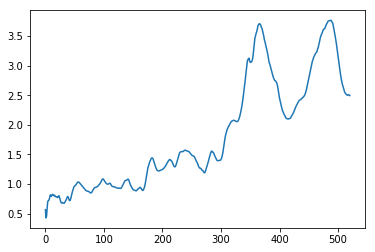

In [416]:
plt.plot(attn.sum(1))

In [417]:
y = attn.cumsum(0)/attn.sum(0).reshape(1,-1)
rngy = np.logical_and(y>0.2, y<0.8).sum(0)

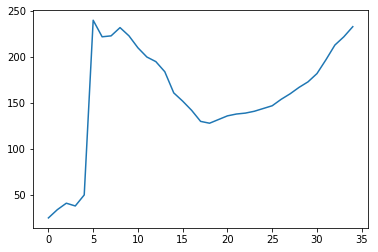

In [418]:
plt.plot(rngy)

In [321]:
tq = np.abs(attn).sum(1)


(521,)

In [322]:
tq.shape[0]

521

In [331]:
for stopi in range(1, tq.shape[0]):
    col_sum = np.abs(attn[:stopi, :]).sum(0)
    
    if type(tq[stopi]) == np.float32:
        if tq[stopi] < 0.5 and col_sum[-1] > 4:
            break
    else:
        if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
            break

In [317]:
d = NpzFolder(dataset + '/numpy_features_valid').dict
revd = dict()
for k, v in d.iteritems():
    revd[v] = k 

In [318]:
print [revd[l] for l in loss_workings['txt'][idx]]

['ay', 'hh', 'ow', 'p', 'dh', 'ax', 'v', 'ow', 't', 'er', 'z', 'w', 'ih', 'l', 'r', 'ih', 's', 'p', 'aa', 'n', 'd', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']


## Rebuilding eval stats from saved checkpoints
09-Jul-2018

Running a big baseline sim and saving the checkpoint at each epoch. Now want to recalculate the evaluation metrics.

In [2]:
for i in range(1,10):
    print i

1
2
3
4
5
6
7
8
9


### Recalc eval stats on a single checkpoint
* 16-Jul-2018
* Returning to this after ICML etc. 
* Trying to remember exactly what was going on with all the bits of code and get them properly tidied up now

In [2]:
import eval_curves as ec

In [34]:
tm = ec.calc_eval_curves(checkpoint_folder='checkpoints/vctk-us-train-mon',
                     data='/home/ubuntu/loop/data/vctk',
                     speaker_recognition_checkpoint='checkpoints/speaker-recognition-vctk-us/bestmodel.pth',
                     speaker_recognition_exp_name='speaker-recognition-vctk-us',
                     max_seq_len=1000,
                     nspk=22,
                     gpu=0,
                     batch_size=64,
                     seed=1,
                     eval_epochs=1,
                     b_teacher_force=True,
                     b_use_train_noise=False)

Valid:   0%|          | 0/11 [00:00<?, ?it/s]

epoch 1: speaker recognition 1.000


Loss 28.31: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]   


,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,1.0,16-Jul-2018 10:10:38,26.443173,28.157477,4.984542,1.0


In [73]:
tm.disp()

,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,163.0,16-Jul-2018 13:47:12,32.21482,32.907606,4.885905,0.995677


In [72]:
tm.data

,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,163.0,1.531749e+09,32.21482,32.907606,4.885905,0.995677


In [36]:
l = LossDecomposition(tm)

In [37]:
l.load_all_loss_contribs()

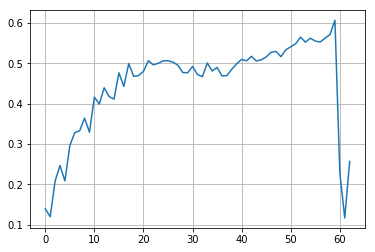

In [38]:
plt.plot(l.get_loss_by_feature().transpose())
plt.grid(True)
plt.show()

In [53]:
tm = ec.calc_eval_curves(checkpoint_folder='checkpoints/vctk-all-2-v2',
                     data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                     speaker_recognition_checkpoint='checkpoints/speaker_recognition_vctk_all/bestmodel.pth',
                     speaker_recognition_exp_name='notebook_test',
                     max_seq_len=1000,
                     nspk=107,
                     gpu=0,
                     batch_size=64,
                     seed=1,
                     eval_epochs=1,
                     b_teacher_force=True,
                     b_use_train_noise=True,
                     start_epoch=163,
                     end_epoch=163,
                     eval_metrics = ('loss', 'loss_workings', 'speaker_recognition')
                     )

Valid (loss 32.25) epoch 163: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it]


,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,163.0,16-Jul-2018 13:47:12,32.21482,32.907606,4.885905,0.995677


In [76]:
l = LossDecomposition(tm)
l.load_all_loss_contribs()

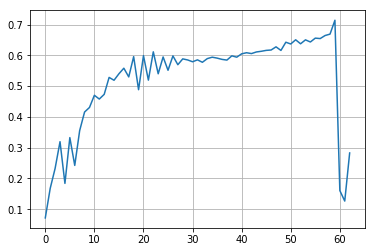

In [77]:
plt.plot(l.get_loss_by_feature().transpose())
plt.grid(True)
plt.show()

In [78]:
tm = ec.calc_eval_curves(checkpoint_folder='checkpoints/vctk-all-2-v2',
                     data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all',
                     speaker_recognition_checkpoint='checkpoints/speaker_recognition_vctk_all/bestmodel.pth',
                     speaker_recognition_exp_name='notebook_test',
                     max_seq_len=1000,
                     nspk=107,
                     gpu=0,
                     batch_size=64,
                     seed=1,
                     eval_epochs=1,
                     b_teacher_force=True,
                     b_use_train_noise=False,
                     start_epoch=163,
                     end_epoch=163,
                     eval_metrics = ('loss', 'loss_workings', 'speaker_recognition')
                     )

Valid (loss 28.36) epoch 163: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]


,epoch,update_time,train_loss,valid_loss,mcd,speaker_recognition_acc_eval
0,163.0,16-Jul-2018 13:58:28,28.591618,29.36662,4.478442,0.994476


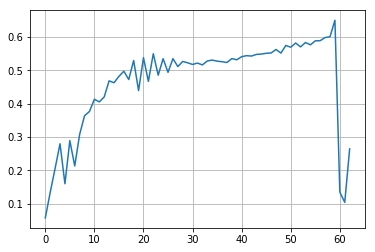

In [79]:
l = LossDecomposition(tm)
l.load_all_loss_contribs()
plt.plot(l.get_loss_by_feature().transpose())
plt.grid(True)
plt.show()

In [82]:
range(2,10,2)

[2, 4, 6, 8]